In [1]:
%%capture
!pip install PyDrive
!pip install gensim
!pip install pyldavis
!python -m spacy download en
!pip install nltk
!pip install wordcloud
!pip install bertopic

In [6]:
!pip install seaborn

     -------------------------------------- 288.2/288.2 kB 8.7 MB/s eta 0:00:00


In [2]:
# from google.colab import drive
# #drive.mount('/drive')  # Add My Drive/<>

# import os
# #os.chdir("/drive/My Drive/NLPProject")
# drive.mount('/content/drive')
# os.chdir("drive/My Drive/NLP")
#os.chdir("Project")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import warnings
warnings.filterwarnings("ignore")

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

c:\Users\coder\anaconda3\envs\NLP\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    name=b'"verified": \"true\",'
    l=l.replace(b'"verified": true,',bytes(name))
    name1=b'"verified": \"false\",'
    l=l.replace(b'"verified": false,',bytes(name))
    yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
df1 = getDF('AMAZON_FASHION.json.gz')
df1.shape

(883636, 12)

In [5]:
df2 = getDF('meta_AMAZON_FASHION.json.gz')
df2.shape

(186637, 16)

In [6]:
df1.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,true,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,true,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN


In [7]:
df1.dropna(subset=['reviewText'],inplace=True)

In [8]:
df=df1[df1.overall<2.0].reset_index()

In [9]:
thresh_50Percent = len(df)/2
df1.dropna(thresh=thresh_50Percent, axis=1, inplace=True)

In [10]:
df.shape

(106984, 13)

In [11]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

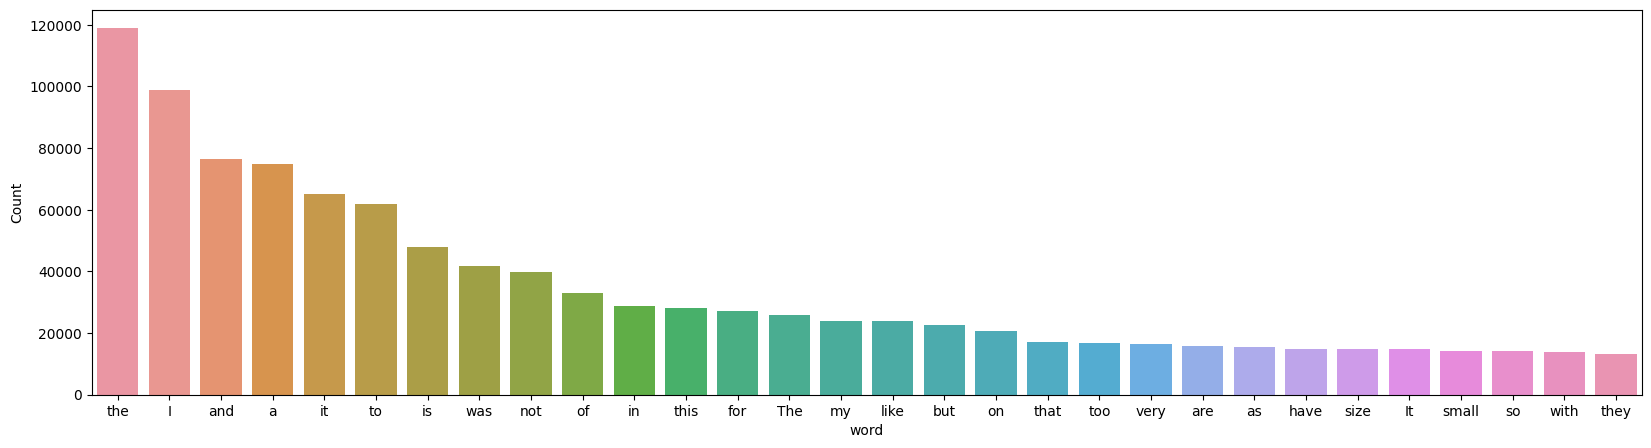

In [12]:
freq_words(df['reviewText'])

In [13]:
# function to remove stopwords
def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new

In [14]:
#remove stop words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
add_stop_words = ['good', 'great', 'perfect','love','like','would','nice','beautiful',\
                  'excellent','loved','thank','recieved','fast','exactly','expected','really','got',\
                  'product','perfectly','honest','also','review','super']
stop_words = stop_words.union(add_stop_words)

def stopText(text_array):
    h2 = ""
    for h in text_array:
        if h.lower() not in stop_words:
          h2 = h2 + ' ' + h
    return h2


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
import string
# Remove punctuations
def removePuncStr(s):
    for c in string.punctuation:
        s = s.replace(c," ")
    return s

def removePunc(text_array):
    return [removePuncStr(h) for h in text_array]

# Remove numbers
def removeNumbersStr(s):
  for c in range(10):
    n = str(c)
    s = s.replace(n,"")
  return s

def removeNumbers(text_array):
    return [removeNumbersStr(h) for h in text_array]

In [16]:
df['reviewText'] = df['reviewText'].apply(lambda x: removePuncStr(x))
df['reviewText'] = df['reviewText'].apply(lambda x: removeNumbersStr(x))
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
df['reviewText'] = df['reviewText'].apply(lambda x: str(x).lower())
df['reviewText'] = df['reviewText'].apply(lambda x: stopText(x.split()))

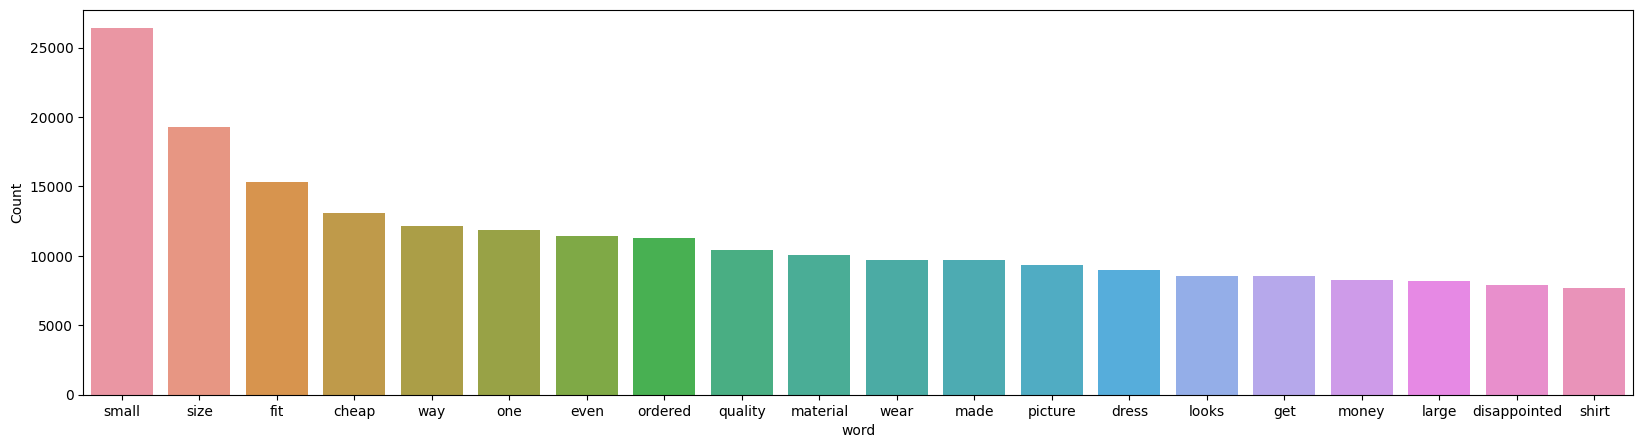

In [17]:
freq_words(df['reviewText'], 20)

In [18]:
# Stemming
nltk.download('punkt')
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
def stemText(text):
    words = word_tokenize(text)
    stemmed_text = ''
    for w in words:
        stemmed_text = stemmed_text + ' ' + PorterStemmer().stem(w)
    return stemmed_text

In [20]:
def lemmText(text):
    WNlemmatizer = WordNetLemmatizer()
    lemmatized_text = ''

    words = word_tokenize(text) 
    for w in words:
        lemmatized_text = lemmatized_text + ' ' + WNlemmatizer.lemmatize(w)
    return lemmatized_text


In [21]:
# df['reviewText'] = df['reviewText'].apply(lambda x: stemText(x))
df['reviewText'] = df['reviewText'].apply(lambda x: lemmText(x))

In [22]:
reviewText = " ".join(review for review in df['reviewText'])

c:\Users\coder\anaconda3\envs\NLP\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\coder\anaconda3\envs\NLP\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\coder\anaconda3\envs\NLP\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\coder\anaconda3\envs\NLP\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_s

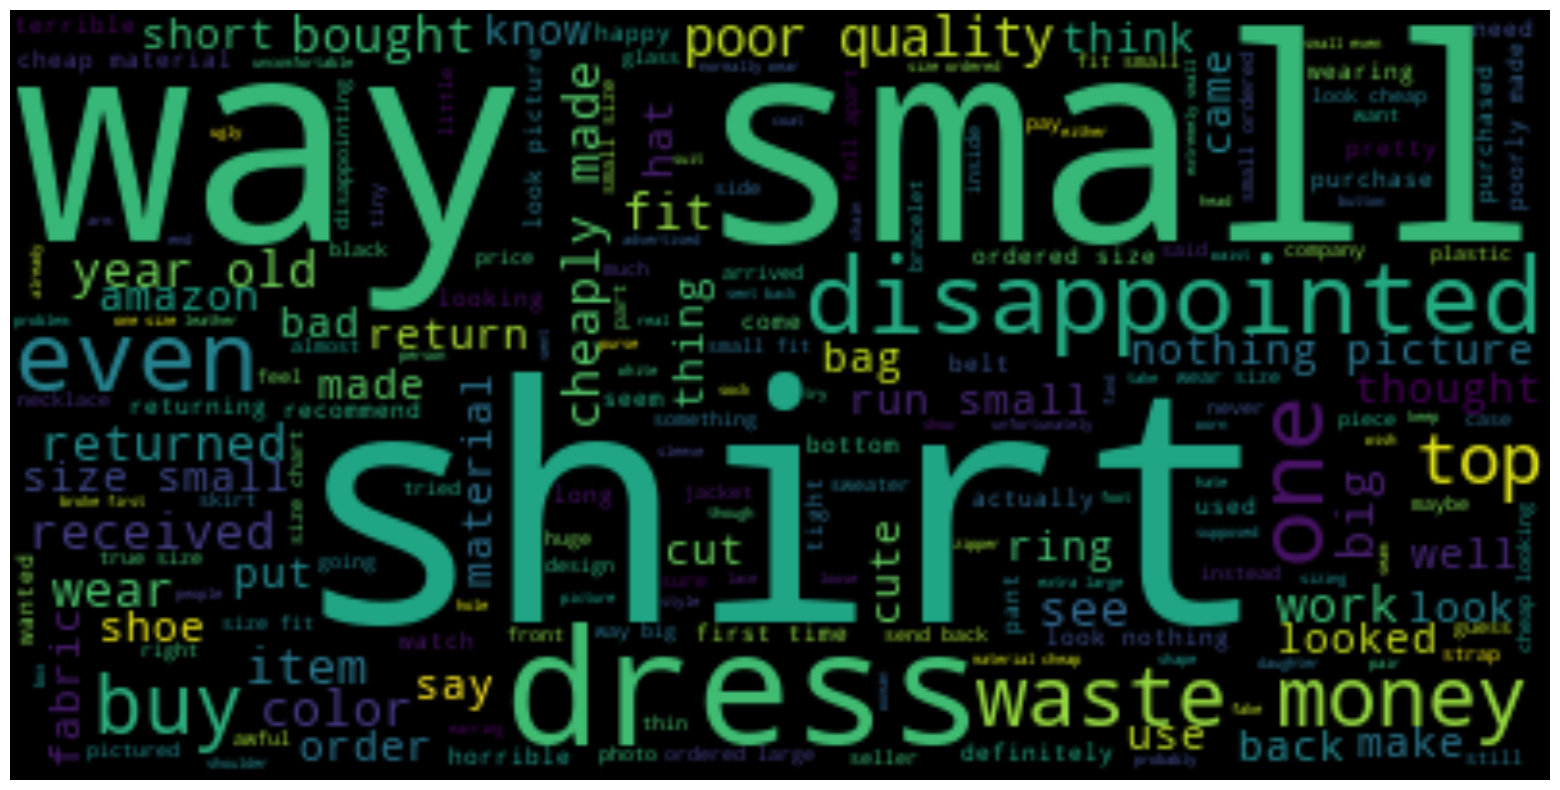

In [23]:
from wordcloud import WordCloud
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(reviewText)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
%%capture
# Install bertopic
!pip install bertopic

In [25]:
df_test = df

In [26]:
df_test.shape

(106984, 13)

In [33]:
# Topic model
from bertopic import BERTopic
# Dimension reduction
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
# Initiate UMAP
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(df_test['reviewText'], show_progress_bar=False)
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=10)

# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=False, low_memory=True,vectorizer_model=vectorizer_model,  embedding_model=sentence_model)
# Run BERTopic model
topics, probabilities = topic_model.fit_transform(df_test['reviewText'], embeddings)

In [34]:
from sklearn.metrics import silhouette_score
# Generate `X` and `labels` only for non-outlier topics (as they are technically not clusters)
umap_embeddings = topic_model.umap_model.transform(embeddings)
indices = [index for index, topic in enumerate(topics) if topic != -1]
X = umap_embeddings[np.array(indices)]
labels = [topic for index, topic in enumerate(topics) if topic != -1]

# Calculate silhouette score
silhouette_score(X, labels)

0.6497478

In [31]:
# Get the list of topics
topic_model.get_topic_info()[1:21]

,Topic,Count,Name
1,0,1458,0_earring_ear_post_plug
2,1,1295,1_small small_small_def_close small
3,2,1208,2_smell_smelled_chemical_odor
4,3,991,3_dress_dress look_dress dress_dress picture
5,4,984,4_necklace_jewelry_pendant_costume jewelry
6,5,895,5_hat_head_smashed_cap
7,6,885,6_shirt_shirt size_shirt small_size shirt
8,7,786,7_swimsuit_suit_bathing_bathing suit
9,8,765,8_late_blah_non_lol
10,9,745,9_zipper_zipper broke_zipper broken_zip


In [29]:
# Get top 10 terms for a topic
topic_model.get_topic(6)

[('shirt', 0.01094208596049575),
 ('shirt size', 0.010736495118780711),
 ('shirt small', 0.010491258148170965),
 ('size shirt', 0.010043362428659658),
 ('shirt way', 0.009238867797725115),
 ('large shirt', 0.008744382709211235),
 ('shirt fit', 0.008543776089718997),
 ('small shirt', 0.008062875465038907),
 ('ordered shirt', 0.006948286813976896),
 ('shirt ordered', 0.006517081281773661)]

In [30]:
# Visualize top topic keywords
topic_model.visualize_barchart(topics=[4,6,8,9,17,18],n_words=8, width=300)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.003506289187333949, 0.0041382631076163695,
                    0.004160290001544056, 0.004217009196782988,
                    0.008480972523290106, 0.011400768806709245,
                    0.015428206950916238, 0.04257214175718513],
              'xaxis': 'x',
              'y': [chain  , clasp  , piece jewelry  , broken  , costume jewelry
                    , pendant  , jewelry  , necklace  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.008062875465038907, 0.008543776089718997,
                    0.008744382709211235, 0.009238867797725115,
                    0.010043362428659658, 0.010491258148170965,
                    0.010736495118780711, 0.01094208596049575],
              'xaxis': 'x2',
              'y': [small shirt  , shirt fit  , large shirt  , shirt way  , size
                    shirt  , shirt small  , shirt size  , shirt  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [1e-05, 1e-05, 1e-05, 1e-05, 0.3838646235656288,
                    0.4732000809353412, 0.5244621320602986, 0.5487031499382695],
              'xaxis': 'x3',
              'y': [  ,   ,   ,   , lol  , non  , blah  , late  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.004661622599041639, 0.005049969761524491,
                    0.006739597866072898, 0.0071300801052355724,
                    0.013011447432021876, 0.015760204337162798,
                    0.04243525452885111, 0.052768317435176744],
              'xaxis': 'x4',
              'y': [broken  , broke time  , zipped  , broke  , zip  , zipper
                    broken  , zipper broke  , zipper  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.010658665567544688, 0.01293639013030176,
                    0.013328401952432118, 0.01336917318805942, 0.01350657267372654,
                    0.018802271325256862, 0.023045455245850787,
                    0.03219152759002517],
              'xaxis': 'x5',
              'y': [gave star  , deserve star  , negative star  , star star  ,
                    deserve  , zero  , zero star  , star  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.005358876272090274, 0.0067592593795623305,
                    0.0069128492242859566, 0.007243360611129883,
                    0.00925964021246766, 0.010298499181175256,
                    0.011520400834052476, 0.03358989174040134],
              'xaxis': 'x6',
              'y': [bag disappointed  , carry  , backpack  , bag look  , wheel  ,
                    luggage  , handle  , bag  ],
              'yaxis': 'y6'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 4',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 6',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                              

In [ ]:
tokenized_reviews = df['reviewText'].apply(lambda x: x.split())
print(tokenized_reviews[1])

['exactly', 'wanted']


In [66]:
import gensim
from gensim import corpora

In [67]:
doc_clean = [doc.split() for doc in df_test['reviewText']]
dictionary = corpora.Dictionary(doc_clean)

In [68]:
#Unique words in the dictionary
len(set(dictionary))

10838

In [69]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [70]:
#check few properties of the matrix
print(len(doc_term_matrix))
print(type(doc_term_matrix))
print(len(doc_term_matrix[0]))
print(len(doc_term_matrix[1]))

30000
<class 'list'>
1
1


In [74]:
%%time 
#RUN THE MODEL
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=10, 
                random_state=100,
                chunksize=10000,
                passes=10)

CPU times: user 1min 39s, sys: 3.05 s, total: 1min 42s
Wall time: 1min 39s


In [75]:
lda_model.print_topics()

[(0,
  '0.058*"boot" + 0.022*"shirt" + 0.016*"jacket" + 0.016*"leather" + 0.011*"toe" + 0.009*"stretcher" + 0.008*"one" + 0.008*"get" + 0.007*"liner" + 0.007*"quality"'),
 (1,
  '0.031*"pair" + 0.024*"ring" + 0.021*"one" + 0.020*"wear" + 0.017*"year" + 0.016*"flip" + 0.015*"flop" + 0.011*"comfortable" + 0.011*"get" + 0.010*"time"'),
 (2,
  '0.039*"foot" + 0.039*"shoe" + 0.028*"support" + 0.024*"arch" + 0.021*"insole" + 0.013*"best" + 0.013*"sock" + 0.012*"day" + 0.012*"pair" + 0.011*"comfortable"'),
 (3,
  '0.036*"well" + 0.021*"fit" + 0.020*"costume" + 0.017*"made" + 0.015*"cute" + 0.015*"color" + 0.014*"bought" + 0.010*"look" + 0.010*"one" + 0.009*"wear"'),
 (4,
  '0.060*"hat" + 0.026*"sun" + 0.025*"fit" + 0.023*"head" + 0.015*"one" + 0.013*"protection" + 0.013*"well" + 0.012*"light" + 0.012*"stay" + 0.011*"face"'),
 (5,
  '0.067*"fit" + 0.037*"size" + 0.025*"comfortable" + 0.024*"pant" + 0.020*"belt" + 0.019*"pocket" + 0.013*"small" + 0.013*"look" + 0.013*"little" + 0.012*"quality"'

In [76]:
# Visualize the 
#read: https://community.alteryx.com/t5/Data-Science/Getting-to-the-Point-with-Topic-Modeling-Part-3-Interpreting-the/ba-p/614992#:~:text=The%20intertopic%20distance%20map%20is,each%20topic%20across%20the%20dictionary.
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.057677 -0.027557       1        1  14.179175
2     -0.147969  0.151657       2        1  14.138677
9      0.194249  0.070106       3        1  12.920945
7     -0.178766  0.171062       4        1  10.995861
1     -0.091675  0.003355       5        1  10.842795
3      0.069526 -0.048665       6        1  10.521896
6     -0.119002 -0.226729       7        1   7.539535
4      0.232270  0.093071       8        1   6.781775
8      0.095165 -0.119451       9        1   6.242560
0     -0.111476 -0.066849      10        1   5.836781, topic_info=        Term         Freq        Total Category  logprob  loglift
1429     hat  3195.000000  3195.000000  Default  30.0000  30.0000
731     shoe  4241.000000  4241.000000  Default  29.0000  29.0000
722     foot  3427.000000  3427.000000  Default  28.0000  28.0000
827     boot  1623.000000  1623.000000  Default  27.0000  27.0000
33       fit  6873.000000  6873.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
177    could    98.327644   707.660531  Topic10  -5.4227   0.8673
57      made   110.521308  1480.810659  Topic10  -5.3058   0.2459
138   bought   103.426072  2444.215568  Topic10  -5.3722  -0.3216
381      day    93.583807  1870.190540  Topic10  -5.4722  -0.1539
79      even    87.585967  1216.851697  Topic10  -5.5384   0.2096

[734 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2809      3  0.146723  accurate
2809     10  0.817455  accurate
590       2  0.915766      ache
590       5  0.066601      ache
4035      2  0.975597    aching
...     ...       ...       ...
2704      1  0.907009    zipper
2704      3  0.089214    zipper
101       3  0.949505  zippered
101       6  0.019378  zippered
3088      3  0.966678    zutano

[1974 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 10, 8, 2, 4, 7, 5, 9, 1])

Positively rated Topics:\
1: Shoes \
2: Clothes\
3: Jewllery\
4: Bags

In [77]:
# Print the Keyword in the 10 topics
lda_model.print_topics()

[(0,
  '0.058*"boot" + 0.022*"shirt" + 0.016*"jacket" + 0.016*"leather" + 0.011*"toe" + 0.009*"stretcher" + 0.008*"one" + 0.008*"get" + 0.007*"liner" + 0.007*"quality"'),
 (1,
  '0.031*"pair" + 0.024*"ring" + 0.021*"one" + 0.020*"wear" + 0.017*"year" + 0.016*"flip" + 0.015*"flop" + 0.011*"comfortable" + 0.011*"get" + 0.010*"time"'),
 (2,
  '0.039*"foot" + 0.039*"shoe" + 0.028*"support" + 0.024*"arch" + 0.021*"insole" + 0.013*"best" + 0.013*"sock" + 0.012*"day" + 0.012*"pair" + 0.011*"comfortable"'),
 (3,
  '0.036*"well" + 0.021*"fit" + 0.020*"costume" + 0.017*"made" + 0.015*"cute" + 0.015*"color" + 0.014*"bought" + 0.010*"look" + 0.010*"one" + 0.009*"wear"'),
 (4,
  '0.060*"hat" + 0.026*"sun" + 0.025*"fit" + 0.023*"head" + 0.015*"one" + 0.013*"protection" + 0.013*"well" + 0.012*"light" + 0.012*"stay" + 0.011*"face"'),
 (5,
  '0.067*"fit" + 0.037*"size" + 0.025*"comfortable" + 0.024*"pant" + 0.020*"belt" + 0.019*"pocket" + 0.013*"small" + 0.013*"look" + 0.013*"little" + 0.012*"quality"'